In this notebook, I try to classify the audio files in the famous GTZAN dataset

I have seen that many people are converting the given 30 sec audio files into 3 second files to increase the data. However, I don't agree with this approach. This is because while splitting the data into training, test and validation sets, the datapoints from the same song would be present in all these sets. This would obviously result in a high accuracy due to the skewed nature of the data.

I have therefore used the original files for classification and not split the data.

<b>Approach:</b>

I first convert the audio files into Mel Spectrograms. Then, I downloaded these Mel Spectrograms as images locally for further use.

These Mel Spectrograms can be now used as the new dataset to classify the genres. Since it is a image classification task, I use a pretrained ResNet18 model for this task.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
from time import time # to import time() as a function, rather than just the time module
from tqdm import tqdm

import librosa
import librosa.display

import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

## Defining Parameters

In [2]:
seed = 42
np.random.seed(seed)

path = "../input/gtzan-dataset-music-genre-classification/"

wav_audio_dataset_path = path + "Data/genres_original/"

spectrogram_images_path = "./mel_spectrogram_imgs/"

learning_rate = 5e-3
batch_size = 128 # OBS ignored
hop_length = 512
n_fft = 2048

genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'

# device = 'cpu'
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.mps.is_available():
#     device = torch.device("mps")  # Metal on macOS

print("Device: ", device)

Device:  mps


## Transforming Audio Files into Mel Spectograms and Saving the Images

In [4]:
if not os.path.exists(spectrogram_images_path):
    print("Transforming the Audio Files into Mel Spectrograms:")

    mel_spectogram_data = {}
    for genre in genre_dict.keys():
        print("\t",genre)
        
        mel_spectogram_data[genre] = []

        for name in glob.glob(wav_audio_dataset_path + genre + "/*"):
            
            if(name != "../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav"):
            
                data,sampling_rate = librosa.load(name)

                mel_spec = librosa.feature.melspectrogram(y = data.ravel(), sr=sampling_rate,hop_length = hop_length)
                mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

                mel_spectogram_data[genre].append(mel_spec_db)
                

    print("Saving the Mel Spectrogram Images:")
    os.mkdir(spectrogram_images_path)
    for genre in genre_dict.keys():
        print("\t",genre)
        try:
            os.mkdir(spectrogram_images_path + genre)
        except:
            pass
        
        for i in range(len(mel_spectogram_data[genre])):

            fig, ax = plt.subplots(1, figsize=(12,8))

            img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,cmap = 'cool',ax=ax)

            fig.savefig(spectrogram_images_path + genre + "/" + genre + "_" + str(i) + ".png")
            
            plt.close()

In [5]:
import gc
gc.collect() # to free up memory

0

## Load and Transform the Data

### Get dataset statistics

In [6]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Temporary transform to load data as tensors
# temp_transform = transforms.Compose([transforms.ToTensor()])
# temp_dataset = datasets.ImageFolder(spectrogram_images_path, transform=temp_transform)
# temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False)

# # Calculate mean and std
# mean = 0.0
# std = 0.0
# total_images = 0

# for images, _ in temp_loader:
#     batch_samples = images.size(0)  # Batch size (number of images)
#     images = images.view(batch_samples, images.size(1), -1)  # Flatten H and W
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     total_images += batch_samples

# mean /= total_images
# std /= total_images

# print(f"Calculated mean: {mean}, Calculated std: {std}")

### dataset statistics

In [7]:
# mean.shape, std.shape

# Calculated mean: tensor([0.4716, 0.9263, 0.9964]), tensor([0.4526, 0.1533, 0.0568])
# default values: mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602]
# default function: tensor([-0.0471,  0.0633,  0.0071]) tensor([1.0106, 0.9319, 0.9437]) # before
# default function: tensor([-0.0545,  0.0830,  0.0078]) tensor([0.9974, 0.7766, 0.4186]) # after new normalization

### Create DataLoaders

In [8]:
torch.manual_seed(seed)

mean, std = torch.tensor([0.4716, 0.9263, 0.9964]), torch.tensor([0.4526, 0.1533, 0.0568])

# Define Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images for ResNet
    # transforms.Resize(224), 
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])  # Normalization
    transforms.Normalize(mean=mean, std=std)  # Normalization

])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images for ResNet
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])  # Normalization
    transforms.Normalize(mean=mean, std=std)  # Normalization
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(spectrogram_images_path)
print("Size of Dataset: ", len(dataset)) # 1000

# Split the data into Train and Validation
train_split = 0.7
val_split = 0.15

train_size = int(train_split * len(dataset))  # 70% for training
val_size = int(val_split * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Stratified split (manual implementation using indices)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Applying transforms to datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# Create data loaders

# optimized batch sizes
train_bs = (train_size+1) // 2  # 50% of training data
# train_bs = (train_size+3) // 4 # 25% of training data
val_bs = len(val_dataset)
test_bs = len(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False)

# Checking dataset split sizes
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train batch size: {train_bs}, Val batch size: {val_bs}, Test batch size: {test_bs}")


Size of Dataset:  999
Train size: 699, Val size: 149, Test size: 151
Train batch size: 350, Val batch size: 149, Test batch size: 151


### old [bad] mean & std function

In [9]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

# mean, std = mean_std(train_dataloader)
# print("mean and std: \n", mean, std)

## ResNet18 - Transfer Learning
- Load a Pretrained Model

In [10]:
from torchvision.models import ResNet18_Weights
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet)

### freeze params, fc-layer, Optimizer

In [11]:
# Classes
classes = train_dataloader.dataset.dataset.classes
print("Classes: ", classes)

# Fix the trainable parameters
for parameter in resnet.parameters():
    parameter.requires_grad = False
    
    
# Number of Input Features in the Last Fully Connected Layer
in_features = resnet.fc.in_features
print("Number of Input Features in the Last Fully Connected Layer: ", in_features)

# Replacing the Last Fully Connected Layer
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet.fc = fc


# Updating the Weights and Bias of the last layer
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Define the Loss and Optimizer Functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate) # default lr = 0.001

Classes:  ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Number of Input Features in the Last Fully Connected Layer:  512


## Training the Model

In [12]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epoch, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    no_improve_epochs = 0
    
    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        start_time = time()

        running_loss, val_loss = 0, 0
        correct_train, total_train = 0, 0
        correct_val, total_val = 0, 0

        # Training the model
        model.train()
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() # clear gradients for next train
            # Forward pass
            output = model(images)
            loss = criterion(output, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Logging Training Loss and Accuracy
            running_loss += loss.item()
            correct_train += (output.argmax(1) == labels).sum().item()
            total_train += labels.size(0) # accumulated number of imagess from all batches in the epoch
            
        # Validating the model
        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                val_loss += criterion(output, labels).item()
                correct_val += (output.argmax(1) == labels).sum().item()
                total_val += labels.size(0)
        
        train_losses.append(running_loss / len(train_dataloader)) # average loss per batch (i.e. per 50% of training data)
        val_losses.append(val_loss / len(val_dataloader)) # average val loss per batch (i.e. per 100% of validation data)

        print(f"Train Loss: {train_losses[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, "
              f"Train Acc: {correct_train / total_train * 100:.2f}%, Val Acc: {correct_val / total_val * 100:.2f}%")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve_epochs = 0
            torch.save(model.state_dict(), "best_model.pth")
            if correct_val / total_val > 0.70:
                torch.save(model.state_dict(), f'checkpoint_{correct_val / total_val * 100:.2f}', _use_new_zipfile_serialization=True)
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

    return model, train_losses, val_losses

  2%|▏         | 1/50 [00:08<07:17,  8.92s/it]

Train Loss: 2.622, Val Loss: 2.464, Train Acc: 10.73%, Val Acc: 16.11%


  4%|▍         | 2/50 [00:17<07:07,  8.90s/it]

Train Loss: 2.379, Val Loss: 2.242, Train Acc: 19.60%, Val Acc: 10.07%


  6%|▌         | 3/50 [00:26<06:57,  8.89s/it]

Train Loss: 2.024, Val Loss: 2.373, Train Acc: 29.04%, Val Acc: 12.08%


  8%|▊         | 4/50 [00:35<06:46,  8.83s/it]

Train Loss: 1.864, Val Loss: 2.109, Train Acc: 35.34%, Val Acc: 24.83%


 10%|█         | 5/50 [00:44<06:34,  8.77s/it]

Train Loss: 1.650, Val Loss: 1.932, Train Acc: 44.35%, Val Acc: 28.19%


 12%|█▏        | 6/50 [00:52<06:22,  8.70s/it]

Train Loss: 1.570, Val Loss: 1.868, Train Acc: 46.21%, Val Acc: 34.90%


 14%|█▍        | 7/50 [01:01<06:14,  8.70s/it]

Train Loss: 1.419, Val Loss: 1.866, Train Acc: 56.37%, Val Acc: 34.23%


 16%|█▌        | 8/50 [01:10<06:05,  8.69s/it]

Train Loss: 1.362, Val Loss: 1.711, Train Acc: 58.08%, Val Acc: 40.94%


 18%|█▊        | 9/50 [01:18<05:56,  8.70s/it]

Train Loss: 1.270, Val Loss: 1.544, Train Acc: 61.09%, Val Acc: 46.31%


 20%|██        | 10/50 [01:27<05:46,  8.66s/it]

Train Loss: 1.218, Val Loss: 1.433, Train Acc: 61.80%, Val Acc: 55.70%


 22%|██▏       | 11/50 [01:36<05:38,  8.67s/it]

Train Loss: 1.147, Val Loss: 1.408, Train Acc: 64.23%, Val Acc: 54.36%


 24%|██▍       | 12/50 [01:44<05:28,  8.65s/it]

Train Loss: 1.102, Val Loss: 1.431, Train Acc: 67.10%, Val Acc: 53.02%


 26%|██▌       | 13/50 [01:53<05:20,  8.67s/it]

Train Loss: 1.066, Val Loss: 1.321, Train Acc: 69.24%, Val Acc: 53.69%


 28%|██▊       | 14/50 [02:02<05:12,  8.67s/it]

Train Loss: 1.004, Val Loss: 1.246, Train Acc: 70.53%, Val Acc: 59.06%


 30%|███       | 15/50 [02:10<05:03,  8.67s/it]

Train Loss: 0.969, Val Loss: 1.255, Train Acc: 69.38%, Val Acc: 59.73%


 32%|███▏      | 16/50 [02:19<04:55,  8.70s/it]

Train Loss: 0.936, Val Loss: 1.251, Train Acc: 71.67%, Val Acc: 57.05%


 34%|███▍      | 17/50 [02:28<04:48,  8.75s/it]

Train Loss: 0.903, Val Loss: 1.213, Train Acc: 73.68%, Val Acc: 60.40%


 36%|███▌      | 18/50 [02:37<04:39,  8.74s/it]

Train Loss: 0.874, Val Loss: 1.177, Train Acc: 74.54%, Val Acc: 61.74%


 38%|███▊      | 19/50 [02:45<04:31,  8.74s/it]

Train Loss: 0.848, Val Loss: 1.182, Train Acc: 75.39%, Val Acc: 59.06%


 40%|████      | 20/50 [02:54<04:22,  8.75s/it]

Train Loss: 0.828, Val Loss: 1.190, Train Acc: 76.11%, Val Acc: 59.73%


 42%|████▏     | 21/50 [03:03<04:15,  8.82s/it]

Train Loss: 0.799, Val Loss: 1.171, Train Acc: 77.40%, Val Acc: 59.73%


 44%|████▍     | 22/50 [03:12<04:06,  8.81s/it]

Train Loss: 0.778, Val Loss: 1.148, Train Acc: 78.25%, Val Acc: 59.73%


 46%|████▌     | 23/50 [03:21<03:57,  8.79s/it]

Train Loss: 0.757, Val Loss: 1.163, Train Acc: 78.68%, Val Acc: 59.06%


 48%|████▊     | 24/50 [03:29<03:48,  8.77s/it]

Train Loss: 0.737, Val Loss: 1.155, Train Acc: 79.26%, Val Acc: 57.05%


 50%|█████     | 25/50 [03:38<03:39,  8.79s/it]

Train Loss: 0.713, Val Loss: 1.127, Train Acc: 81.26%, Val Acc: 63.76%


 52%|█████▏    | 26/50 [03:47<03:30,  8.77s/it]

Train Loss: 0.699, Val Loss: 1.127, Train Acc: 81.55%, Val Acc: 60.40%


 54%|█████▍    | 27/50 [03:56<03:22,  8.78s/it]

Train Loss: 0.679, Val Loss: 1.150, Train Acc: 82.55%, Val Acc: 58.39%


 56%|█████▌    | 28/50 [04:04<03:12,  8.77s/it]

Train Loss: 0.669, Val Loss: 1.134, Train Acc: 82.98%, Val Acc: 58.39%


 58%|█████▊    | 29/50 [04:13<03:04,  8.77s/it]

Train Loss: 0.643, Val Loss: 1.115, Train Acc: 83.26%, Val Acc: 60.40%


 60%|██████    | 30/50 [04:22<02:55,  8.76s/it]

Train Loss: 0.633, Val Loss: 1.116, Train Acc: 84.55%, Val Acc: 59.73%


 62%|██████▏   | 31/50 [04:31<02:46,  8.76s/it]

Train Loss: 0.618, Val Loss: 1.129, Train Acc: 84.69%, Val Acc: 57.72%


 64%|██████▍   | 32/50 [04:39<02:37,  8.77s/it]

Train Loss: 0.602, Val Loss: 1.113, Train Acc: 85.41%, Val Acc: 60.40%


 66%|██████▌   | 33/50 [04:48<02:29,  8.80s/it]

Train Loss: 0.587, Val Loss: 1.112, Train Acc: 85.98%, Val Acc: 61.07%


 68%|██████▊   | 34/50 [04:57<02:20,  8.78s/it]

Train Loss: 0.575, Val Loss: 1.120, Train Acc: 86.55%, Val Acc: 55.70%


 70%|███████   | 35/50 [05:06<02:11,  8.79s/it]

Train Loss: 0.565, Val Loss: 1.109, Train Acc: 87.27%, Val Acc: 58.39%


 72%|███████▏  | 36/50 [05:15<02:03,  8.81s/it]

Train Loss: 0.555, Val Loss: 1.108, Train Acc: 87.41%, Val Acc: 59.06%


 74%|███████▍  | 37/50 [05:24<01:54,  8.82s/it]

Train Loss: 0.540, Val Loss: 1.101, Train Acc: 87.41%, Val Acc: 59.73%


 76%|███████▌  | 38/50 [05:32<01:45,  8.78s/it]

Train Loss: 0.532, Val Loss: 1.110, Train Acc: 87.98%, Val Acc: 58.39%


 78%|███████▊  | 39/50 [05:41<01:36,  8.76s/it]

Train Loss: 0.513, Val Loss: 1.126, Train Acc: 89.27%, Val Acc: 57.72%


 80%|████████  | 40/50 [05:50<01:27,  8.78s/it]

Train Loss: 0.504, Val Loss: 1.105, Train Acc: 89.56%, Val Acc: 58.39%


 82%|████████▏ | 41/50 [05:59<01:19,  8.80s/it]

Train Loss: 0.494, Val Loss: 1.096, Train Acc: 89.99%, Val Acc: 59.73%


 84%|████████▍ | 42/50 [06:07<01:10,  8.79s/it]

Train Loss: 0.482, Val Loss: 1.106, Train Acc: 89.84%, Val Acc: 58.39%


 86%|████████▌ | 43/50 [06:16<01:01,  8.76s/it]

Train Loss: 0.475, Val Loss: 1.107, Train Acc: 90.70%, Val Acc: 59.06%


 88%|████████▊ | 44/50 [06:25<00:52,  8.75s/it]

Train Loss: 0.468, Val Loss: 1.108, Train Acc: 90.84%, Val Acc: 57.72%


 90%|█████████ | 45/50 [06:34<00:43,  8.74s/it]

Train Loss: 0.455, Val Loss: 1.096, Train Acc: 91.27%, Val Acc: 60.40%


 92%|█████████▏| 46/50 [06:42<00:35,  8.75s/it]

Train Loss: 0.447, Val Loss: 1.105, Train Acc: 91.27%, Val Acc: 59.73%


 94%|█████████▍| 47/50 [06:51<00:26,  8.73s/it]

Train Loss: 0.442, Val Loss: 1.120, Train Acc: 90.84%, Val Acc: 57.72%


 96%|█████████▌| 48/50 [07:00<00:17,  8.76s/it]

Train Loss: 0.432, Val Loss: 1.102, Train Acc: 92.42%, Val Acc: 58.39%


 98%|█████████▊| 49/50 [07:09<00:08,  8.75s/it]

Train Loss: 0.423, Val Loss: 1.097, Train Acc: 92.27%, Val Acc: 59.06%


 98%|█████████▊| 49/50 [07:17<00:08,  8.94s/it]

Train Loss: 0.415, Val Loss: 1.105, Train Acc: 92.27%, Val Acc: 59.06%
Early stopping triggered.


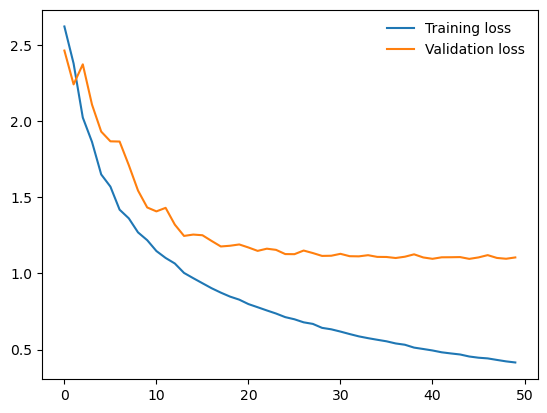

CPU times: user 6min 12s, sys: 1min 34s, total: 7min 46s
Wall time: 7min 17s


In [13]:
%%time
num_epoch = 50 # default 100

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epoch=num_epoch,
    patience=5
)

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Testing

In [14]:

def evaluate(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100

test_accuracy = evaluate(resnet, test_dataloader)
print(f'Test accuracy: {test_accuracy:.2f}%')
print(f'{num_epoch} epochs, batch size {train_dataloader.batch_size}: Acc {test_accuracy:.4g}%')

Test accuracy: 62.91%
50 epochs, batch size 350: Acc 62.91%


## Results

lr = e-2
- 20 epochs, batch size 350: Acc 58.28%
- 65/100 epochs, batch size 699: Acc 62.25%
- 19/100 epochs, batch size 175: Acc 61.59% 3min

Karpathy's learning rate 3e-4
- e-4: 100 epochs, batch size 699: Acc 61.59%
- 100 epochs, batch size 699: Acc 52.98% (14min 39s) - 3e-4
- 49/50 epochs, batch size 350: Acc 62.91% - 5e-3

### 8 epochs: val acc

128
- batch size  32, acc 40.00%, 6min 39s
- batch size 128: acc 23.18%, 72.62s
- batch size 128: acc 23.18%: 73.8s
- batch size 128: acc 49.01%: 92.3s
- batch size 128: acc 49.01%: 96.09s

256
- batch size 256: acc 42.38%: 74.39s
- batch size 256: acc 27.15%: 74.66s

No normalization:
- batch size 128: acc 29.14%: 88.52s
-  batch size 128: acc 31.79%: 92.31s (bad norm)

Full run (50 epcochs)
- deafult Accuracy: 66.6666
- 17:46 11/1 val Accuracy 67.67, test acc 69.70%

cpu vs mps
- 1 epoch cpu: Wall time: 4min 31s CPU times: user 14min 37
- 1 epoch mps: Wall time: 16.8 s CPU times: user 11.7 s

### Lessons Learned
- Always use mps! 10x speedup
- this script requires at least 2 batches with print_every = 2 
    - batch_size = dataset=1 // 2 was therefore optimal
- very small batch sizes e.g. 499+499=1 gives bad optimization and slower

### F1 classification_report

In [15]:
from sklearn.metrics import classification_report

# Collect all true labels and predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=classes))

              precision    recall  f1-score   support

       blues       0.56      0.56      0.56        16
   classical       0.75      0.82      0.78        11
     country       0.67      0.53      0.59        19
       disco       0.63      0.57      0.60        21
      hiphop       0.67      0.77      0.71        13
        jazz       0.73      0.67      0.70        12
       metal       0.67      0.83      0.74        12
         pop       0.80      0.47      0.59        17
      reggae       0.79      0.73      0.76        15
        rock       0.33      0.53      0.41        15

    accuracy                           0.63       151
   macro avg       0.66      0.65      0.64       151
weighted avg       0.66      0.63      0.63       151



## Loading the model

### load model from last checkpoint


In [16]:
# model = torch.load('checkpoint_72.00')
# model.to(device) 

# latest_checkpoint = 
# state_dict = torch.load(latest_checkpoint)
# resnet.load_state_dict(state_dict)
# resnet.to(device)

# resnet.eval()
# print('evaluating checkpoint:', latest_checkpoint)
# test_accuracy = evaluate(resnet, test_dataloader)
# print(f'Test accuracy: {test_accuracy:.2f}%')

### Loading the fully trained model

In [17]:
# model = torch.load('checkpoint_72.00', map_location='mps')
# torch.save(model, 'resnet_model2.pth', _use_new_zipfile_serialization=True)

# Checkpoint_72.00 is saved with the default serialization method and 'cpu'
# loaded_model = torch.load('resnet_model.pth', map_location='cpu', weights_only=True)
# test_accuracy = evaluate(loaded_model, test_dataloader)
# print(f'Test accuracy: {test_accuracy:.2f}%')

In [18]:
# load the model from disk
# from torch.nn import Conv2d
# from torch.nn import BatchNorm2d
# from torch.nn import ReLU
# from torch.nn import MaxPool2d
# from torch.nn import Sequential
# from torch.nn import AdaptiveAvgPool2d
# from torch.nn import Linear

# # import the BasicBlock class
# from torchvision.models import ResNet
# from torchvision.models.resnet import BasicBlock

# torch.serialization.add_safe_globals([Sequential])
# torch.serialization.add_safe_globals([Linear])
# torch.serialization.add_safe_globals([ReLU])
# torch.serialization.add_safe_globals([set])
# torch.serialization.add_safe_globals([Conv2d])
# torch.serialization.add_safe_globals([BatchNorm2d])
# torch.serialization.add_safe_globals([MaxPool2d])
# torch.serialization.add_safe_globals([AdaptiveAvgPool2d])

# torch.serialization.add_safe_globals([ResNet])
# torch.serialization.add_safe_globals([BasicBlock])

# loaded_model = torch.load('resnet_model.pth', weights_only=True, map_location='mps')

# # evaluate the model
# test_accuracy = evaluate(loaded_model, test_dataloader)
# print(f'Test accuracy: {test_accuracy:.2f}%')

This seems to be a good baseline model for this task.

I'll be trying to improve the performance by including more preprocessed features which I have detailed in [this notebook](https://www.kaggle.com/code/nippani/preprocessing-audio-data-gtzan).

If you liked this notebook, please upvote.

Also, do let me know if there are any corrections/additions needed.